# Bayesian Data Analysis

## Probabilistic principal component analysis in STAN

Illustration of PPCA using Stan for model parameter estimation




In [1]:
import numpy as np
import pystan
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import linalg
# edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))

/Users/nbip/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


PPCA is seen as a linear mapping from from a lower dimensional subspace with a latent variable $z$ to data-space, with added noise,

$$y=Wz+\epsilon, \quad \epsilon \sim N(0,\sigma^2I)$$

There is a prior distribution for the latent variable

\begin{equation}
 p(z) = N(z | 0,I)   
\end{equation}

and we have a conditional distribution for the observed data

\begin{align}
 p(y | z) = N(y | Wz, \sigma^2I)
\end{align}

The model parameters are the transformation matrix $W$ and the noise variance $\sigma^2$

This notebook aims to
* get posterior samples for the transformation matrix
* get posterior samples for the noise variance
* get posterior samples for the latent variables

## Create data
Create data using the generative model $y = Wz + \epsilon$

In [2]:
def createData(d,dl,n,mu,sigma2):
    # sample latent variable Z
    Z = np.random.multivariate_normal(np.zeros(dl),np.identity(dl),n).T  # dl x n
    # create orthogonal signal directions
    W = linalg.orth(np.random.random((d,dl)))  # d x dl
    # create additive noise
    noise = np.random.multivariate_normal(np.zeros(d),sigma2*np.identity(d),n).T  # d x n
    
    # data-space data
    Y = np.dot(W,Z) + noise;
    
    return dict(Y=Y,W=W,Z=Z)

Change the number of dataspace dimensions and latent space dimensions here. Visualization only works for $d=2$ and $dl=1$

In [3]:
d=2     # data space dimensions
dl=1    # latent space dimensions
mu = np.zeros(d)
sigma2 = 0.05
n=500
data = createData(d,dl,n,mu,sigma2)

In [4]:
W = data['W']
Y = data['Y']
Z = data['Z']

## Latent distribution
Illustrate the latent variables and the distribution they are drawn from. Follow one single observation, here marked by a red star, through the rest of the notebook

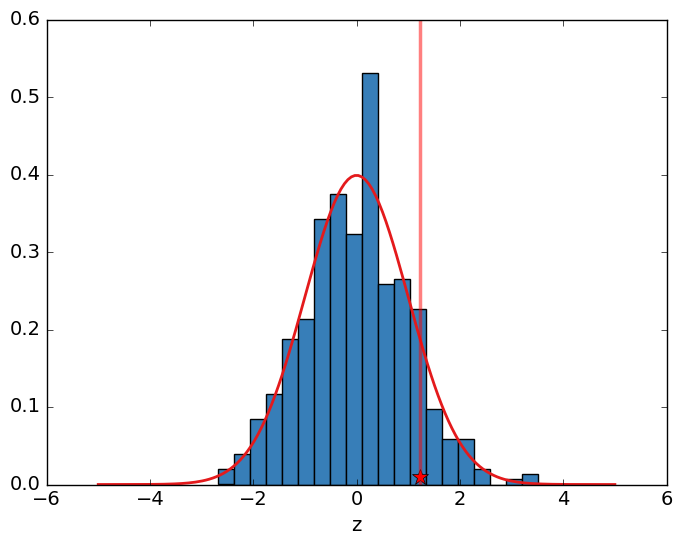

In [5]:
# plot the latent variables
plt.hist(Z[0,:],20,normed=True);

# plot the prior distribution they are drawn from
from scipy.stats import norm
l = np.linspace(-5,5,150)
pd = norm.pdf(l)
plt.plot(l,pd)

# plot one single latent variable
plt.plot(Z[0,0],0.01,'r*',markersize=12.)
plt.xlabel('z')
plt.axvline(Z[0,0], color='#ff0000', linewidth=2.5, alpha=0.5);



## Data distribution
Illustrate the data distribution. The red star from above is shown as mapped with and without noise



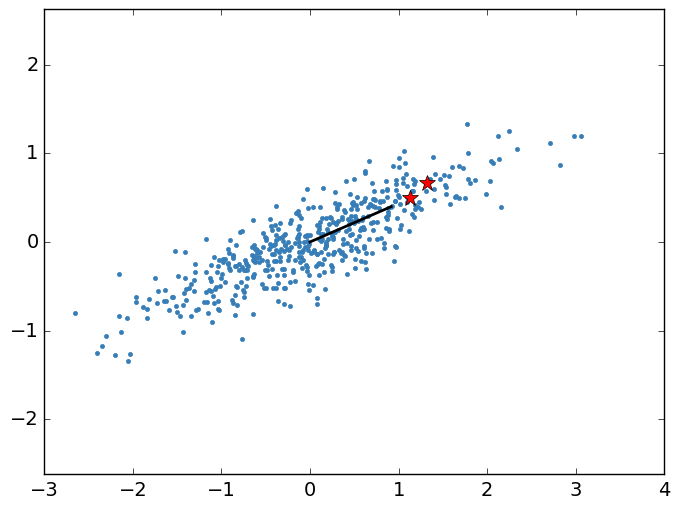

In [6]:
# data
plt.plot(Y[0,:],Y[1,:],'.')

# same observation as the latent above
plt.plot(Y[0,0],Y[1,0],'r*',markersize=12)
# same observation, but mapped without noise
z_ = np.dot(W,Z[:,0])
plt.plot(z_[0],z_[1],'r*',markersize=12)

# principal component
plt.plot([0,W[0]],[0,W[1]],'k')
plt.axis('equal');

## Estimate parameters and posterior on latent variables using Stan

In [7]:
# =============== PPCA model ===================
ppca_code = """
data {
  int<lower=1> N;              // num datapoints
  int<lower=1> D;              // num data-space dimensions
  int<lower=1> K;              // num latent space dimensions
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;                  // identity matrix
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;          // zero vector
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;            // transformation matrix / PCs
  vector[K] x[N];           // latent variables
  real<lower=0> sigma;      // noise variance
}
model {  
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);     // zero-mean, identity matrix
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));           
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=dl, ones=1, y=Y)
fit = pystan.stan(model_code=ppca_code, data=data)
print(fit)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a213df6c2be095068d5c5c48a42604e6 NOW.


Inference for Stan model: anon_model_a213df6c2be095068d5c5c48a42604e6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]        -0.46    0.57    0.8  -0.99  -0.94  -0.91   0.09   0.97      2  27.91
A[1,0]         -0.2    0.25   0.36  -0.44  -0.42   -0.4   0.03   0.43      2  22.62
x[0,0]        -0.69    0.86   1.22  -1.81  -1.47  -1.28   0.11   1.67      2   5.86
x[1,0]        -0.08    0.11   0.26  -0.56  -0.25  -0.09    0.1   0.45      6    1.2
x[2,0]         0.28    0.37   0.53  -0.85  -0.03   0.46   0.64   0.96      2    2.5
x[3,0]         0.16     0.2   0.35  -0.59  -0.09   0.22   0.41   0.71      3   1.65
x[4,0]         0.95    1.17   1.66  -2.16  -0.19   1.81    2.0   2.32      2    8.0
x[5,0]        -0.22    0.25   0.44  -0.85  -0.54  -0.34   0.05   0.73      3   2.05
x[6,0]         -0.6    0.75   1.06  -1.61   -1.3  -1.11

## Transformation matrix (principal components)
The column vectors of the transformation matrix $W$ spans the principal subspace, but does not necessarily give the "traditional" principal components. In order to get these, orthonormalize the solution

In [8]:
A = samples['A']
A = A[:,:,0]
W_est = np.mean(abs(A.T),1)[np.newaxis]   
# newaxis becuase the mean of A is just a 1D array and in Python this cannot be transposed
W_est = linalg.orth(W_est.T)

In [9]:
S = np.sign(samples['A'])
np.unique(S[:,0]*S[:,1])

array([ 1.])

In [10]:
print('The estimated weights are W=[{:f}, {:f}]\n'.format(W_est[0,0],W_est[1,0]))
print('The true weights are W=[{:f}, {:f}]\n'.format(W[0,0],W[1,0]))

The estimated weights are W=[0.914572, 0.404424]

The true weights are W=[0.916992, 0.398906]



## Show posterior samples for the weights

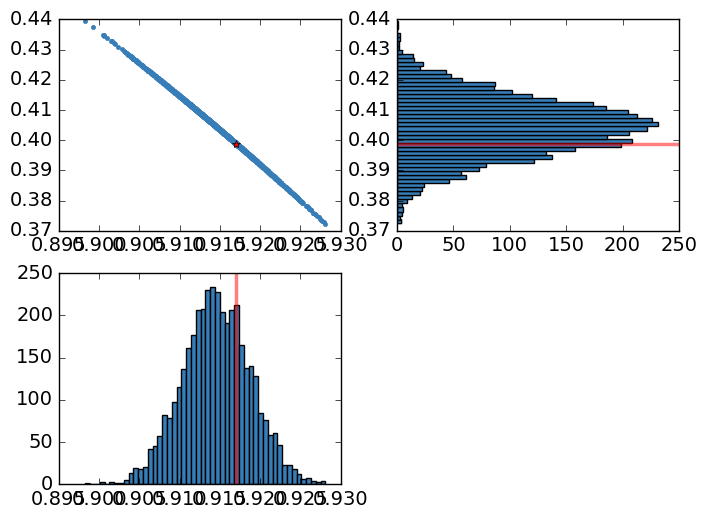

In [11]:
orth_A = np.zeros(A.shape) # initialize empty matrix to hold orthonormalized samples for A

for i in range(0,len(A)):
    orth_A[i,:] = linalg.orth(abs(A[i,:])[np.newaxis].T).T
    

fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.plot(orth_A[:,0],orth_A[:,1],'.')
ax1.plot(W[0],W[1],'r*')
axes = plt.gca()

ax2 = fig.add_subplot(222)
ax2.hist(orth_A[:,1],50,orientation='horizontal')
ax2.axhline(W[1], color='#ff0000', linewidth=2.5, alpha=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(orth_A[:,0],50)
ax3.axvline(W[0], color='#ff0000', linewidth=2.5, alpha=0.5);


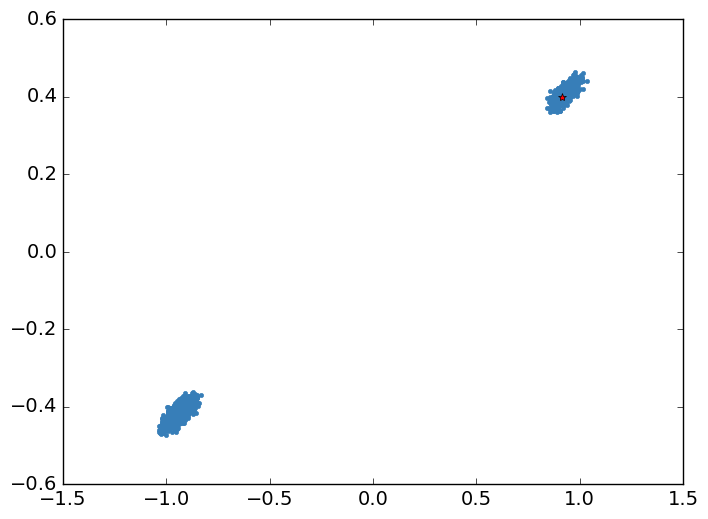

In [12]:
# original samples without orthonormalization
plt.plot(A[:,0],A[:,1],'.')
plt.plot(W[0],W[1],'r*');

## Noise variance

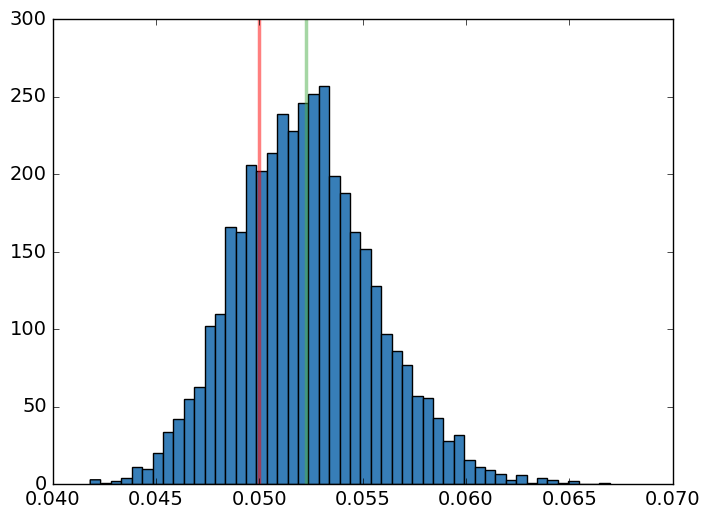

In [13]:
tmp = samples['sigma']
sigma = [x*x for x in tmp];
s2 = np.mean(sigma)
plt.hist(sigma,50)
plt.axvline(s2, color='#4daf4a', linewidth=2.5, alpha=0.5)
plt.axvline(sigma2, color='#ff0000', linewidth=2.5, alpha=0.5)

## Posterior on latent variables
Now we show the posterior samples for the latent observation we showed by a red star earlier in the notebook. Compare this to how much the mapping distorted the observation

In [14]:
x = samples['x']
x = x[:,:,0]

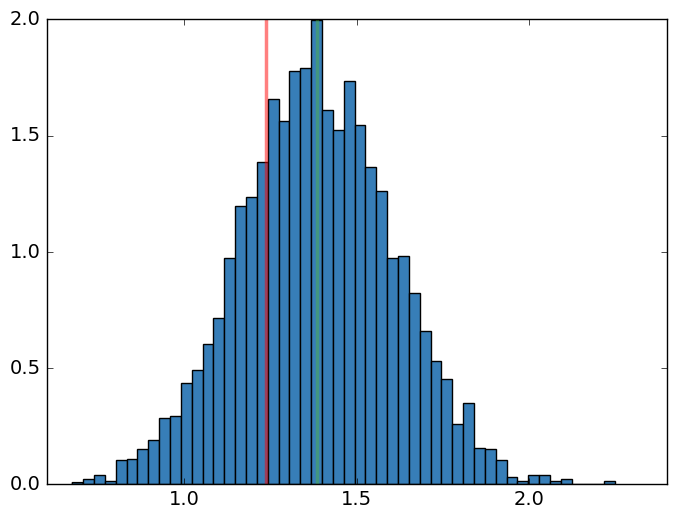

In [15]:
# create a new posterior for the latent variable, taking the sign of the weights into account
x_ = np.zeros(len(x[:,0]))
for i in range(0,len(x[:,0])):
    x_[i] = x[i,0]*S[i,0]
    
plt.hist(x_,50,normed=True);
m1 = np.mean(x_)
plt.axvline(Z[0,0], color='#ff0000', linewidth=2.5, alpha=0.5)
plt.axvline(m1, color='#4daf4a', linewidth=2.5, alpha=0.5);

In [16]:
print('Original latent variable value:{:f}\n'.format(Z[0,0]))
print('Estimated latent varuable value:{:f}\n'.format(m1))

Original latent variable value:1.236619

Estimated latent varuable value:1.383993



The posterior on a latent variable can also be found analytically based on the transformation matrix as

$$p(z|y) = N(z | (W^TW + \sigma^2I)^{-1}y, \sigma^{-2}(W^TW + \sigma^2I))$$

In [17]:
M = np.dot(W_est.T,W_est) + s2*np.identity(dl)
# create pdf for the latent variable
z_mu = np.dot((W_est/M).T,Y[:,0])
z_s2 = (s2/M)[0]

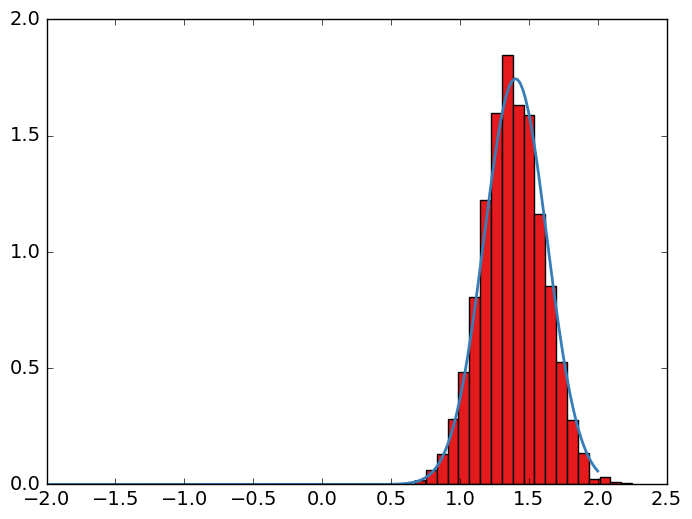

In [18]:
l2 = np.linspace(-2,2,200)
pd2 = norm(z_mu,np.sqrt(s2)).pdf(l2)
plt.plot(l2,pd2)
plt.hist(x_,20,normed=True);